# Decision Trees

This week we will learn about weak learners: specifically, decision stumps and decision trees. This will provide us with the building blocks that we will need for ensemble learning (week 7)

The basic idea behind decision trees is to stack a series of *weak* learning models one on top of another with a view to learning a single strong, generalisable, model. For example consider a simple model of diabetes:

<img src="imgs/tree.png" style="max-width:100%; width: 50%; max-width: none">


Each node in the tree asks a simple question of the data. If the response for a given example is true, its passes down one branch of the tree, if it is false, it passes down the other branch. Each weak learner in a tree is known as **Decision Stump**. 

In [1]:
import sys
sys.executable
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


## Decision Stumps

Learning rules for tree stumps may take many forms including linear and non-linear fits (see figures b and c below); however, most often, classification trees nodes implement axis-aligned learning rules (figure a), which make predictions by thresholding on a single feature:

<img src="imgs/weakleaners.png" style="max-width:100%; width: 70%; max-width: none">

This is the approach taken in Scikit Learn. The choice of threshold is optimised so as to maximally split the different classes of the data. By example, try different ```thresholds``` below so as to maximally separate the classes ```{0,1}``` of the below  ```dataset```. Note, ```dataset``` represents a set of examples with **single feature** (first column); the second column represents the class. The below code seeks to set all data examples strictly below the threshold to the first group and all examples above to the second group; select an appropriate threshold and run the code.


In [2]:
dataset = np.asarray([[1,0],
           [2,0],
           [3,0],
           [4,0],
           [5,0],
           [6,1],
           [7,1],
           [8,1],
           [9,1],
           [10,1]])

threshold=6

group1labels=[]; group2labels=[]

for row in dataset:
        # if the value of this feature for this row is less than the (threshold) value, 
        # split into left branch, else split into right
        if row[0] < threshold:
            group1labels.append(row[1])
        else:
            group2labels.append(row[1])
            
print('With threshold {} the group1labels are {}'.format(threshold, group1labels))
print('With threshold {} the group2labels are {}'.format(threshold, group2labels))

With threshold 6 the group1labels are [0, 0, 0, 0, 0]
With threshold 6 the group2labels are [1, 1, 1, 1, 1]


A biomedical example of such a decision stump is shown for diabetes classification in the figure below. Here, a decision is made by optimising a threshold on blood glucose levels. All examples with blood glucose less than $12mmol/L$ are considered healthy and pass down the left branch. All remaining examples are labelled as diabetic and pass down the right. It is expected that, for most problems, such a simple learning rule will result in many misclassified examples. Therefore, the role of subsequent decision stumps, in the tree, is to further refine the prediction.

<img src="imgs/decisionstump.png" style="max-width:100%; width: 30%; max-width: none">



### Weak Learning rules for classification

We will discuss two options for classification tree cost functions; these are Information Gain and the Gini Index.

- ***Information Gain*** represents the decrease in entropy obtained after a dataset is split on an attribute.

- ***Gini Index*** reflects how mixed the classes are following the split. Perfect separation results in a score of 0, whereas the worst case split (that results in 50/50 classes in each group) results in a Gini score of 0.5 (for a 2 class problem).

The calculation for ***Information Gain*** is as follows:

$$ I(S_j,\theta_j) = H(S_j) - \sum_{i \in {L,R}} \frac{|S_j^i|}{|S_j|}H(S^i_j) $$

Where $H(S_j)$ represents entropy (or the amount of disorder in a system): 

$$H(S_j)=\sum_{y_k \in Y} p(y_k) log_2 p(y_k); $$

Y are the class labels (i.e. {0,1} for a binary problem); $ p(y_k)$ is the proportion of examples that have class $k$ reaching the current (in this case parent) node; $|S_j|$ is the total number of examples reaching node $j$ and $|S_j^i|$ is the number of examples passing down branch $i$ from node $j$.

Looking at a toy example:

<img src="imgs/InformationGainexample.png" style="max-width:100%; width: 70%; max-width: none">

Here, we start with 23 examples at the parent node (14 o and 9 +). We are interested in testing a split that results in the right child node taking 11 instances (4 o and 7 +) and the left child node taking 12 instances (10 o and 2+). We calculate the entropies for the parent node and each child node as follows:


<img src="imgs/InformationGainexample2.png" style="max-width:100%; width: 70%; max-width: none">

The final cost is then estimated from a weighted sum of entropies from each child $H(S^i_j)$:

$$ \frac{11}{23}  \times 0.946 + \frac{12}{23}\times 0.650 =0.792 $$

Subtracted from the original parent entropy ($H(S_j)$):

$$ 𝐼(𝑆_𝑗,\theta_𝑗 )= 0.966−0.792=0.163 $$

Where the weights here are estimated from the proportion of examples in each node relative to that in the parent node i.e. ($\frac{|S_j^i|}{|S_j|}$).

The ***Gini Index*** is estimated as :

$$Gini = 1 -\sum_{y_k\in Y} p(y_k)^2 $$

Where, again, $p(y_k)$ represents the proportion of examples that have class $k$ reaching the node. Thus, estimating this for each child node separately:

<img src="imgs/Gini_example.png" style="max-width:100%; width: 70%; max-width: none">
<a id='gini'></a>
And once again left and right splits are combined as a weighted sum:

$$ I(S_j,\theta_j) = \sum_{i \in {L,R}} \frac{|S_j^i|}{|S_j|}Gini_i $$

Which for this example returns:

$$ 𝐼(𝑆_𝑗,\theta_𝑗 )= \frac{11}{23} \times 0.463 + \frac{12}{23} \times 0.278 =0.366 $$

Note, for datasets containing many categorical variables Information Gain is biased in favour of attributes with more categories; thus, Gini index is default for Scikit-Learn.

Further, remember that when optimising costs, ***Gini Index*** must be ***MINIMISED*** and ***Information Gain*** must be ***MAXIMISED***


## Exercise 1: building a decision stump classifier from scratch

In what follows we will go step by step through the process of building and training a decision stump to perform classification. This will build towards Exercise 2 (optional) where multiple decision stumps are stacked together into a tree

In the first part of the exercise we will use the Gini Coefficient to identify the best split of the data for one node in our tree. To test this we will use the following toy dataset $\mathbf{X}$ made up of ten examples (rows) each with two features (columns 1 and 2) and binary labels (column 3):

In [3]:
X = np.asarray([[2.771244718,1.784783929,0],
           [1.728571309,1.169761413,0],
           [3.678319846,2.81281357,0],
           [3.961043357,2.61995032,0],
           [2.999208922,2.209014212,0],
           [7.497545867,3.162953546,1],
           [9.00220326,3.339047188,1],
           [7.444542326,0.476683375,1],
           [10.12493903,3.234550982,1],
           [6.642287351,3.319983761,1]])

We will go through the process step by step editing the below functions, and testing it on this data, until we are sure our code functions correctly

###  Exercise 1.1: calculate the gini coefficient for a given split

<a id='step1'></a>

First we need to write our own function for evaluating the cost for any proposed split of the data using the Gini Coefficient:

$$Gini = 1 -\sum_{y_k\in Y} p(y_k)^2 $$

In the below function the input will take a list (```branch```) with the total number of examples for each class in the split. Since we have two classes the length of the list must be two and given 10 data examples the sum of this list must be 10. Thus one possible example might be the list  ```[2 8]```). 

Thus we must calculate the gini coefficient by first estimating the total number of examples reaching this tree node. Then estimate the proportions of each class ($p(y_k$) and use this to estimate the coefficient.

Complete the function by replacing all ```None ``` statements with the correct code. 

1. Sum the elements of ```branch``` to estimate total number of examples (```spilt_size```, line 14)
2. Estimate ($p(y_k$): the proportion of total items in the split that belong to each class (line 19)
3. Subtract $p(y_k)^2$ from the current estimate of the Gini Coefficient (line 20). See how here we have initialised our Gini as 1 outside of the loop; we can then iteratively subtract the proportion for each class from this total using the shorthand ```-=``` notation


<details>
  <summary>Click me for hints </summary>

    1. to estimate the total number of examples in a list you might use np.sum 
    2. to estimate ($p(y_k$)) take the specific example [2, 8] 
       - for this given list the total items is 10 and we have 2 elements of class 0 and 8 elements of class 1
    3. As Gini is initialised to 1 we can achieve $gini=(1- \sum_{y_k \in Y} p(y_k)^2)$ by subtracting the proportion (for each class) estimate for each iteration of the loop
    
<details>

In [4]:
def gini_coefficient(branch):
    
    """
        Estimates Gini Coefficient for a given class split
        input:
            split: list of length k (where k= number of classes).
                   The values at each index reflect the toal number of instances 
                   of each class, for this proposed branch split
                             
        output:
            gini: gini coefficient for this split 
    """
    # 1.1.1 estimating total number of samples in branch split (by summing contents of split list)
    split_size=np.sum(branch)
    gini=1
    # iterating over all items in the array branch
    # each item is the total number of samples in each branch 
    for class_total in branch:
        # 1.1.2. estimating p*p for this class label; subtracting from current gini total
        proportion_class_k=(class_total/split_size)
        # 1.1.3. subract the squaree of the propoertion per class from current estimate of the gininindex
        gini-=proportion_class_k*proportion_class_k
        
    return gini

Let's test assume the split of data in our branch is [2,8]:

In [5]:
gini_coefficient([2,8])

0.31999999999999984

###  Exercise 1.2: Propose splits 
<a id='step2'></a>


Now that we are able to estimate the cost of any proposed split we need to be able to generate suggested splits of our dataset. For this we need a function, that given a) some feature to split on (variable ```index``` below = feature/column index) and b) ```value``` = some threshold to split on,  will 
1. check all the values of the features at that indexed position, and 
2. split the data into a left branch (if that data example's feature is below the threshold) and into a right branch (if that data example's feature is below the threshold). We will call this function ```test_split```.

Edit the code here to input an ```if``` statement that checks for each row whether the value of the feature (indicated by the position variable ```index```) is below or above the threshold ```value```. If the feature value is below the threshold then add the row to the '```left```' list; if it is below add it to the '```right```' list. This will require four lines of code (from line 24)

**Note that:***

- ```for row in dataset:``` will slice rows from ```dataset``` so what we are asking you to code is a check against the feature value for the feature located at ``index``` . 
- you need to subsequently choose (based on that threshold) whether you add that row to the ```left``` list or the ```right``` list. How do you add items to a list?


<details>
  <summary>Click me for hints </summary>

    1. for a given row, how do you return the value of the feature at a column position given by 'index'
    2. to add to a list you might want to use 'append'
    
<details>


In [6]:
def test_split(index, value, dataset):
    """
        Split a dataset based on an attribute and an attribute value 
        input:
            index = feature/attribute index (i.e. data column index) on which to split on
            value = threshold value (everything below this goes to left split, 
                    everything above goes to right)
            dataset = array (n_samples,n_features+1) 
                    rows are examples 
                    last column indicates class membership
                    remaining columns reflect features/attributes of data
                             
        output:
            left,right: data arrays reflecting data split into left and right branches, respectively
    """
    
    # create empty list that you will populate with rows of dataset 
    left=[]
    right = []
    # the loop below will slice rows from data set
    for row in dataset:
        # Ex 1.2: if the value of this feature for this row is less than the (threshold) value
        # split into left branch, else split into right
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
	
    return np.asarray(left), np.asarray(right)

**To do** Let's now estimate a split for the 

1. ***first*** feature.  
2. Estimate a threshold corresponding to the value of this feature for 7th data example - note
    - ```rowindex```= 7th row; 
    - value corresponds to sampling from our data matrix $\mathbf{X}$ for this row, column combination) 
    - ***remember in both cases that python indexes from zero!!***
2. Look at $\mathbf{X}$ - is this correct?

In [7]:
index=0
rowindex=6
threshold=X[rowindex,index]
print('the value of the feature {} at row {} of the data set is {}'.format(index,rowindex,threshold))

the value of the feature 0 at row 6 of the data set is 9.00220326


Thus now estimating the split of the data by thresholding on this value gives us

In [8]:
branches=test_split(index, X[rowindex,index], X)

print('Our left branch is \n {}'.format(branches[0]))
print('Our right branch is \n {}'.format(branches[1]))

Our left branch is 
 [[2.77124472 1.78478393 0.        ]
 [1.72857131 1.16976141 0.        ]
 [3.67831985 2.81281357 0.        ]
 [3.96104336 2.61995032 0.        ]
 [2.99920892 2.20901421 0.        ]
 [7.49754587 3.16295355 1.        ]
 [7.44454233 0.47668338 1.        ]
 [6.64228735 3.31998376 1.        ]]
Our right branch is 
 [[ 9.00220326  3.33904719  1.        ]
 [10.12493903  3.23455098  1.        ]]


Thus, branches here is a 2 object tuple, with the first object reflecting the left branch and the second object reflecting the right branch. Note, that this specific notation will be useful for the functions that follow.

###  Exercise 1.3: Estimate total cost of split


So in step 1 we calculate the Gini coefficient for one branch of a split. Let's call this $Gini_i$ (taken notation from [above](#gini)), and in step 2 we defined a function to propose a potential split of the data. 

We now need a function that will estimate the Gini coefficient for both branches of the split and combine to give a final cost:

$$
\begin{align}
I(S_j,\theta_j) && =  && \sum_{i \in {L,R}}  && \frac{|S_j^i|}{|S_j|} && Gini_i \\
&&=  && \sum_{i \in {L,R}} && \frac{total\_examples\_branch_j}{total\_examples\_node} && Gini_i 
\end{align}
$$

The below function:
- estimates $|S_j|$ - the total number across both branches. 
- loops over each branch to estimate the gini cost of each branch;
- then sums the result weighted by the proportion of data in that branch relative to the total reaching the node.

Let's implement this function. 

***To Do***

1. Calculate ```branch_per_class ```: the total number of data examples for a given ```branch``` with class ```class_val`` (line 34)
   - slice all rows from ```branch``` that have class=```class_val``
   - the class labels are stored in the final column of the data matrix
2. count the total number of rows (```total_rows``` with this class (line 36) 
3. Use this to estimate the gini coefficient for that branch - save to variable ```gini_split``` (line 42, using the function estimated from step 1) 
4. calculate  ```weighted_by_sample_size``` - weight this by the proportion of samples that pass down this branch  (line 44) . 

This is then summed over loops (line 46) to estimate gini coefficient for this branch 


<details>
  <summary>Click me for hints </summary>

    1. to return all rows in ```branch ``` corresponding to a specific ```class_val```  you need to consider the last column ```branch[:,-1]``` and slice all rows where this equals ``class_val```
    
<details>

In [9]:
def split_cost(split,classes): 
    
    """
        Estimates the cost for a proposed split 
        input:
            splits: tuple or form (L,R) where L reflects the data for the left split and
                    R reflects data for left split
            classes: list of class values i.e. [0,1]
                             
        output:
            cost: sum of gini coefficient for left and right sides of the split
    """
    cost=0
    total_samples=0
    
    # estimate the relative size of each branch
    for branch in split:
        total_samples+=branch.shape[0]
    
    # for each (left/right) split on the proposed tree
    for br_index,branch in enumerate(split):
        # initialise list of class counts for this branch
        class_counts_for_branch=[]
        # for each class value, count total of data examples (rows) 
        # that have for this class, in this branch 
        for class_val in classes:
            
            if branch.shape[0] == 0: # don't continue if size of split is 0
                continue
           
            # 1.3.1 slice data to return only rows from branch which have this specific class value 
            # here branch[:,-1] returns the column containing the labels and we want to slice all rows 
            # for class=class_val
            branch_per_class=branch[branch[:,-1]==class_val]
            # 1.3.2 count the number of rows with this class in this branch and append 
            total_rows=branch_per_class.shape[0]
            # this is generating list of class counts per branch which get fed to
            # the gini_coefficient function
            class_counts_for_branch.append(total_rows)

        # 1.3.3. estimate the gini coefficient for this split  (or branch)
        gini_split=gini_coefficient(class_counts_for_branch)
        # 1.3.4. estimated the weighted contribution for this split 
        weighted_by_sample_size=gini_split*(branch.shape[0]/total_samples)
        # total cost is a weighted average of gini coefficients for both splits
        cost+=weighted_by_sample_size 
                        
        
    return cost

Let's estimate the total cost of the split proposed from step 2:

In [10]:
class_values=[0,1]
splitcost=split_cost(branches,class_values)

print('The cost of the proposed split is: ', splitcost)

The cost of the proposed split is:  0.375


###  Exercise 1.4: Choose optimal feature/threshold split 

<a id='step4'></a>

Finally, we now need to put this all together by looping through all possible features (all but the last column of our data matrix), and all possible thresholds to determine the best split for this node.

The **output of this function is a dictionary** (see return statement). This saves all variables required for later predicting on that node, specifically: 1) the feature ```index``` that the node is split on; 2) the threshold ```value``` on which the data is split; and 3) the tuple of data arrays reflecting the resulting split (```branches```)

Edit the below function to:

1. edit line 28 to loop over all features (all columns of the dataset, except the last, which instead reflects the class). **hint** define correct range of values  
2. for each index, try proposing splits thresholds from the value of features at each row (line 33) 
  - **hint** look back over the prevous exercises - which one proposes splits of the data? What arguments does it require 
  - **hint** line 31 iterates over rows of the data set - how can you use this to propose a threshold value? 
  - **note** the output ```branches``` will be a tuple containing two data arrays (corresponding to the left and right branches for that split)

3. Given ```branches ``` estimate the ```cost``` of the proposed split (**hint** see Ex 1.3)
4. write an if statement that updates the variables ```best_cost ```, ```best_split ```,  ```best_index ``` and  ```best_value ```  _provided_ that ```cost``` (given in step 3) is better than the one held previously
  - **hint** the cost here is the Gini Index - should it be maximised or minimised?


In [11]:

def get_best_split(dataset):
    """
        Search through all attributes and all possible thresholds to find the best split for the data
        input:
            dataset = array (n_samples,n_features+1) 
                    rows are examples 
                    last column indicates class membership
                    remaining columns reflect features/attributes of data
                             
        output:
            dict containing: 1) 'index' : index of feature used for splittling on
                             2) 'value': value of threshold split on
                             3) 'branches': tuple of data arrays reflecting the optimal split into left and right branches
                             
    """
    
    # estimating the total number of classes by looking for the total number of different unique values 
    # in the final column of the data set (which represents class labels)
    class_values=np.unique(dataset[:,-1])
    
    # initalising optimal values prior to refinment
    best_cost=sys.float_info.max # initialise to max float
    best_value=sys.float_info.max # initialise to max float
    best_index=dataset.shape[1]+1 # initialise as greater than total number of features
    best_split=tuple()     # the best_split variable should contain the output of test_split that corresponds to the optimal cost
    #1.4.1 iterating over all features/attributes (columns of dataset)
    for index in np.arange(dataset.shape[1]-1):

        #Trialling splits defined by each row value for this attribute
        for r_index,row in enumerate(dataset):
           # 1.4.2. return branches corresponding to thresholding on feaure (index) and threshold value (for row r_index)
            branches=test_split(index, row[index], dataset)

            cost=split_cost(branches,class_values) # 1.4.3 estimate cost for this split
            if cost < best_cost: # 1.4.4. if this cost is an improvement on previous costs then save the
                best_cost=cost # cost
                best_split=branches #branches
                best_index=index # feature index
                best_value=row[index] # threshold value
                print('Best cost={}; Best feature={}; Best row={}'.format(best_cost,index,r_index) )
                
    return {'index':best_index, 'value':best_value, 'branches':best_split}


Now, our functions for splitting on a single node are complete, let's find the best split of our toy dataset 

In [12]:
split = get_best_split(X)

print('The optimal left branch is \n {}'.format(split['branches'][0]))
print('The optimal right branch is \n {}'.format(split['branches'][1]))



Best cost=0.4444444444444444; Best feature=0; Best row=0
Best cost=0.2857142857142857; Best feature=0; Best row=2
Best cost=0.1666666666666666; Best feature=0; Best row=3
Best cost=0.0; Best feature=0; Best row=9
The optimal left branch is 
 [[2.77124472 1.78478393 0.        ]
 [1.72857131 1.16976141 0.        ]
 [3.67831985 2.81281357 0.        ]
 [3.96104336 2.61995032 0.        ]
 [2.99920892 2.20901421 0.        ]]
The optimal right branch is 
 [[ 7.49754587  3.16295355  1.        ]
 [ 9.00220326  3.33904719  1.        ]
 [ 7.44454233  0.47668338  1.        ]
 [10.12493903  3.23455098  1.        ]
 [ 6.64228735  3.31998376  1.        ]]


The expected result is

<img src="imgs/optimal_split.png" style="max-width:100%; width: 50%; max-width: none">


## Stacking Stumps into Trees

The video below presents a simple cartoon of a non-linearly separable multi-class classification problem. Here, we have five classes: pink asterisks, yellow question marks, red plus signs, blue crosses and dark green, open circles. The objective is to separate these on two features: $x_1$ and $x_2$. A decision tree may achieve this by stacking axis-aligned decision stumps one after another. In this example, the root node splits first on $x_1$ (orange dotted line). This broadly separates the blue crosses and dark green open circles, from red plus signs, pink asterisks and yellow question marks. In the second level (green dotted line) the second stump thresholds on $x_2$, splitting pink asterisks from yellow crosses. In the final level (black dotted line) a second threshold on $x_1$ splits the red plus signs from these partitions. At this stage, each leaf in the tree is assigned a label, based on the majority class of all training examples which reach that leaf. In this way, leaf nodes may determine the prediction for each new example which reach that leaf at test time.     


In [13]:
import io
import base64
from IPython.display import HTML

video = io.open('RFclassifier.mp4', 'r+b').read()
encoded = base64.b64encode(video)
# HTML(data='''  <video   alt="test" controls>
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii')))

HTML("""
<video width="1000" height="500" controls>
  <source src="RFclassifier.mp4" type="video/mp4">
</video>
""")

This simplicity confers certain advantages:
- it returns learning models which are easy to interpret 
- Requires little data preparation (no normalization)
- Is able to handle both numerical and categorical data. 
- Is able to handle multi-output (multi-class) problems.

For regression, the approach is similar: a series of thresholds are made on the x-axis, and for each split a function is fit to minimise the error between true and predicted y values. In this case (and as standard for scikit learn implementations) the function fits a constant prediction at each split i.e. y = 0.6 and -1.1 for the left and right branches of the first split. As more and more splits are made the tree is able to estimate a closer and closer fit to this sinusoidal function.

In [14]:
HTML("""
<video width="1000" height="500" controls>
  <source src="RFregression.mp4" type="video/mp4">
</video>
""")

In what follows we will build from our decision stump classiifer to create a full decision tree classifier learning algorithm. This section is optional but incorporates the ideas of learning a nested dictionary which stores the parameters of the weak learning rules for each stump in the tree:

## (optional) Exercise 2: building and testing a complete decision tree

<a id='Ex2'></a>

Once we are able to evaluate the best split on a single node of a tree we can then start to think about building nodes together in order to refine prediction of class labels from our data. 

To complete this we need three more things:

1. A function that assigns each leaf (terminal) node a label (associated with the most common label of training points reaching that node)
2. A recursive function that decides (based on the configuration of data reaching each node) on whether to continue splitting the data or to assign that node a terminal node
3. A function that recursively splits data (according to pt 2) in order to build a  tree


### Exercise 2.1 labelling leaf nodes

The goal of our tree is to make a prediction of class labels for unseen data. For classification problems, this means that each terminal node must have an assigned class. We do this by picking the most popular label from the training data that reach that class.

EDIT the below function to:

1. from ```outcomes``` (class labels of the training set) estimate ```counts```: the total number of instances of each class (***HINT*** see numpy documentation for ```np.bincount```)
    - bincount expects an integer array - os you must cast as type in using the .astype() attribute of numpy i.e. outcomes.astype(int)
    
2. finally return ```most_common_class```: the class with the biggest contribution to ```counts``` (***HINT***  ```np.argmax```)


In [15]:
# Create a terminal node value
def to_terminal(group):
    
    """
        Assigns a label according to the most common class label of the data
        input:
            group = array (n_samples,n_features+1) 
                    rows are examples 
                    last column indicates class membership
                    remaining columns reflect features/attributes of data
                             
        output:
            class label for this terminal node
    """
    
    # set outcomes equal to the final column of the input array  
    # - as this indicates the labels of the training data 
    outcomes = group[:,-1]
    counts = np.bincount(outcomes.astype(int))
    most_common_class=np.argmax(counts)
    return most_common_class

Now test on the split received by the left branch of the above example

In [16]:
left_label=to_terminal(split['branches'][0])

print('The label assigned to the left branch is:', left_label)

The label assigned to the left branch is: 0


### Exercise 2.2. Recursively learning the full tree

The next step is to generate a function (```run_split```) that will recursively split the data until a termination criterion is met. Termination criteria include:
- the case where all examples are assigned to a single branch (and thus cannot be further subdivided)
- the case where the node has reach a predefined ```max_depth``` for the tree
- the case where the total number of examples reaching the node as reached or exceeded a pre-defined ``min_size```

The input to the below function is a dictionary (here ```node``` ) representing the results output from ***Ex1.4*** containing the keys: ```index``` (feature that the node is split on), ```value``` (threshold on which the data is split) and ```branches``` (the tuple of data arrays reflecting the resulting split).

The function starts by first extracting the split data from the node dictionary (key='```branches```') and then deleting this information from the node, such that the node can then be cleanly updated as a terminal node or split again.

Then the code checks serially through all possible outcomes for the node:
1. In the case that either the left or right branch of the split is empty, then ignore these branches and set this node as a terminal node; estimate the label for this prediction using ```to_terminal``` (STEP 1, above)
2. In the case that the node is at the ```max_depth``` allowed for this tree then assign as terminal and estimate the label for this prediction using ```to_terminal``` (again STEP 1, above)
3. In the case that the number of examples reaching the node is equal to or less than the ```min_size``` then, again, assign as terminal estimate the label for this prediction using ```to_terminal``` from STEP 1 above
4. Finally, assuming that we instead have nodes that support further splits, for each ```left``` and ```right``` branches in turn, estimate ```get_best_split``` and then run the recursion (call ```run_split``` again)

Note, a recursive function is a function which calls itself.

Please familiarise yourself with the code of this function, to be sure that you understand exactly what each line of code is doing. Identify which lines correspond to each of points 1-4 above.

In [17]:
              
def run_split(node, max_depth, min_size, depth):
     
    """
        Recursively splits nodes until termination criterion is met
        input:
            node = dict containing: 1) 'index' : index of feature used for splittling on
                             2) 'value': value of threshold split on
                             3) 'branches': tuple of data arrays reflecting the optimal split into left and right branches
            max_depth: int determining max allowable depth for the tree
            min_size : int determining minimum number of examples allowed for any branch
            depth: current depth of tree              
            
            
        Output:
            node: is returned by value and returns a recursion of dicts representing the structure of the whole tree
    """
    left, right = node['branches']
    del(node['branches'])
    # check for whether all data has been assigned to one branch; if so assign both branches the same label
    if left.shape[0]==0 :
        node['left'] = node['right'] = to_terminal(right)       
        return
    if right.shape[0]==0 :
        node['left'] = node['right'] = to_terminal(left)       
        return
    # check for max depth; if exceeded then estimate labels for both branches
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
        # in first instance check whether the number of examples reaching the left node are less than the allowed limit
        # if so assign as a terminal node, if not then split again
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_best_split(left)
        run_split(node['left'], max_depth, min_size, depth+1)
    
    # process right child as for left
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_best_split(right)
        run_split(node['right'], max_depth, min_size, depth+1)

### Exercise 2.3 Build the tree

Finally, pool everything together through a top level ```build_tree``` function. Replace each ```None``` in this function with the correct code for complete construction of a tree through:

1. create a root node split by calling ```get_best_split``` ([STEP 4](#step4)) on the full training set
2. recursively building the rest of the tree by calling ```run_split``` (with argument ```root``` as the input argument ```node```) 

These  completely specify the tree.

In [18]:
def build_tree(train, max_depth, min_size):
    """
    Builds and returns final decision tree
    
    input:
        train : training data array (n_samples,n_features)
        max_depth: user defined max tree depth (int)
        min_size: user defined minimum number of examples per tree tree depth (int)
    """
    # create a root node split by calling get_best_split on the full training set
    root = get_best_split(train)
    # now build the tree using run_split
    run_split(root, max_depth, min_size, 1)
    return root

Let's test our code on our full data set. Please edit the below call so that it trains on the full data set ```dataset``` with ```max_depth```= 3 and ```min_size```= 1

In [19]:
tree = build_tree(np.asarray(dataset), 3, 1)
print('Decision Tree: \n {}'.format(tree))

Best cost=0.5; Best feature=0; Best row=0
Best cost=0.4444444444444444; Best feature=0; Best row=1
Best cost=0.375; Best feature=0; Best row=2
Best cost=0.2857142857142857; Best feature=0; Best row=3
Best cost=0.1666666666666666; Best feature=0; Best row=4
Best cost=0.0; Best feature=0; Best row=5
Best cost=0.0; Best feature=0; Best row=0
Best cost=0.0; Best feature=0; Best row=0
Decision Tree: 
 {'index': 0, 'value': 6, 'left': {'index': 0, 'value': 1, 'left': 0, 'right': 0}, 'right': {'index': 0, 'value': 6, 'left': 1, 'right': 1}}


As you can hopefully see, the left and right keys of the dictionary, also contain dictionaries at nodes where the data can be split further. 

### Part 3: Making Predictions

Now that we have our tree we can make predictions. For this we require anpther recursive function that this time, checks whether the ```left``` and ```right``` branches at each new depth reflect new node dicts (in which case ```predict_row``` is called again recurvsively); otherwise, if a terminal node has been reached, the function returns a predicted class label:


In [20]:
def predict_row(node, row):
    
    """
    Predict from a decision tree, by interogating node branches recursively
    
    input:
        node = decision tree represented as dict containing: 
                1) 'index' : index of feature used for splittling on
                2)  'value': value of threshold split on
                3) 'branches': tuple of data arrays reflecting the optimal split into left and right branches
        row: - single row of test data matrix    
       
    """
    if row[node['index']] < node['value']:
         # if the result for the left branch returns another dictionary then repeat
        if isinstance(node['left'], dict):
            return predict_row(node['left'], row)
        else:
            # else if it's an integer you've reached a terminal node so return label
            return node['left']
    else:
         # if the result for the right branch returns another dictionary then repeat
        if isinstance(node['right'], dict):
            return predict_row(node['right'], row)
        else:
            # else if it's an integer you've reached a terminal node so return label
            return node['right']

Now taking a new data example ```[8.5,4.32,1]```, let us predict the correct label:

In [21]:
testdata=np.asarray([8.5,4.32,1])

prediction=predict_row(tree, testdata)
print('Expected={}, Got={}'.format(testdata[-1], prediction))


Expected=1.0, Got=1


Finally the below two functions will allow you to 1) predict for more than test example and 2) return a score - this will allow you to test the tree you have built against the scikit learn implementation

In [22]:
def predict(tree,testdata):
    """
    Predict labels for a test data set
    
    input:
        tree = decision tree represented as dict containing: 
                1) 'index' : index of feature used for splittling on
                2)  'value': value of threshold split on
                3) 'branches': tuple of data arrays reflecting the optimal split into left and right branches
        test data: - an entire test data matrix    
    
    output: 
        predictions - predicted labels for all examples
    """
    
    predictions=[]
    for row in testdata:
        node=deepcopy(tree)
        predictions.append(predict_row(node, row))
        
    return predictions

def tree_score(testlabels, prediction):
    """
    Return prediction score
    
    input:
        testlabels: ground truth labels
        prediction: predicted labels
       
    output:
        score - accuracy of model
    """
    
    score=0
    for i in np.arange(len(testlabels)):
        if testlabels[i]==prediction[i]:
            score+=1
           
    return score/len(testlabels)


##  Tree Pruning

Decision Trees are prone to overfitting, as increasing the number of splits means that data becomes subdivided into leaves at ever finer levels of granularity - increasing the chance that the decision function becomes fit to noise in the data. This will reduce the generalisation performance, leading to lower test accuracies.

For this reason all standard implementations of decision trees also offer pruning. This reduces overfitting by removing branches that contribute least to the prediction accuracy. Example methods for pruning include:

- ***Reduced error pruning:*** starting from leaves, nodes are removed whilst prediction accuracy is unaffected
-  ***Cost complexity pruning:*** This generates a series of trees where  𝑇_0  is the initial tree and 𝑇_𝑀  represents the result of pruning everything away and leaving the root alone. The algorithm obtains these trees through iterative process. At each step:
<br>
    - Remove a subtree from tree 𝑖−1, where the specific subtree to remove is chosen by minimizing: 
    
    <br>
    $$\frac{𝑒𝑟𝑟(𝑇_𝑖 )−𝑒𝑟𝑟(𝑇_{i−1}}{|𝑇_{𝑖−1} | − |𝑇_𝑖|} $$
    <br>
    Then the best tree is selected from the list: 𝑇_0 …. 𝑇_𝑀  so as to optimise training accuracy


## Decision Trees for Regression

The basic algorithm for Regression Trees is the same for classification; however we must modify our cost and change how we make predictions from leaf nodes. 

For cost we can use Mean Squared Error (MSE), which minimises the L2 loss relative to the prediction. The prediction can be made several ways from the data reaching the node (see below figure): either through a constant function (that just fits the mean); a polynomial function (straight line or curve) fit more closely to the data. It is even possible to use a probabilistic model [Criminisi 2013] 

<img src="imgs/DT_regression_predictor_models.png" style="max-width:100%; width: 70%; max-width: none">

In Scikit_Learn and most standard implementations simply the mean (case (a)) is used. MSE is then estimated as:

$$ MSE= \frac{1}{N} \sum_k ^N (y_k-\bar{y}_k)^2 $$

Where, $y_i$ is the true label and $\bar{y}_i$ is the mean of all data samples reaching that child node. The full cost of any split is again modelled as a weighted sum of costs for all child nodes:

$$ I(S_j,\theta_j) = \sum_{i \in {L,R}} \frac{|S_j^i|}{|S_j|}MSE_i $$


## Exercise 3 -  Running Decision Trees with Scikit-Learn

In this final exercise we will practice building Decision Tree classifiers using Scikit-Learn. Complete the below cell to

1. instantiate a decision tree classifier model (line 29)
2. fit the model to training data (line 30)
3. Predict test labels (line 31)
4. Return performance score on test examples (line 32)


Scikit-learn's decision tree Score 0.95


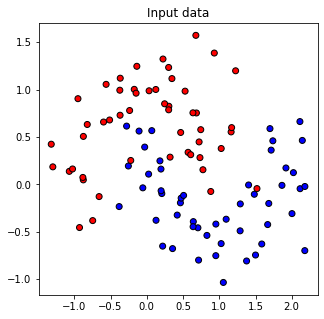

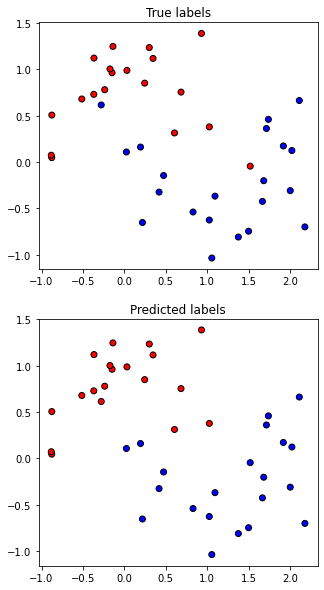

In [23]:
# import the scikit-Learn Decision Tree module
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

# CREATE a Random Data set using the sklearn Make Moons dataset

DATA, LABELS =make_moons(noise=0.3, random_state=0)

# Plot the data 

figure = plt.figure(figsize=(5, 5))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1,1, 1)

ax.set_title("Input data")
ax.scatter(DATA[:, 0], DATA[:, 1], c=LABELS, cmap=cm_bright,
           edgecolors='k')

# randomly split the data
X_train, X_test, y_train, y_test = train_test_split(DATA, LABELS, test_size=.4, random_state=42)

# **to DO** implement scikit learn decision tree classifier on this data
#**** complete the above steps for the scikit learn classifier ******
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train,y_train)
pred=model.predict(X_test)
score = model.score(X_test, y_test)

print("Scikit-learn's decision tree Score", score)

# OPTIONALLY plot your results
# suggest plotting with  with different colours for each class 
#and different markers for test and train data in order to aid visualisation

# just plot the dataset first
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(5,10))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

ax1.set_title("True labels")
ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k')

ax2.set_title("Predicted labels")
ax2.scatter(X_test[:, 0], X_test[:, 1], c=pred, cmap=cm_bright,
           edgecolors='k')

### Ex 3.2 (optional) Compare performance of scikit-Learn against your Decision Tree classifer

You may wish to compare the performance of scikit learn against the Decision Tree classifier you have built during the session. 

In [24]:
# first combine X_train and y_train togeher (and X_test, y_test) to put data into form expected by our tree
dataset=np.concatenate((X_train,y_train.reshape((y_train.shape[0],1))),axis=1)
test_dataset=np.concatenate((X_test,y_test.reshape((y_test.shape[0],1))),axis=1)

#3.2.1 train your tree - set max depth to 5 and min size to 1
tree = build_tree(dataset, 5,1)

#3.2.2 Get a prediction from your test data
prediction_DT1=predict(tree, test_dataset)

#3.2.3 Score the accuracy of your decision tree classifier
score_DT1=tree_score(y_test,prediction_DT1)
print('Our Decision Tree Score', score_DT1)

Best cost=0.46028271773825813; Best feature=0; Best row=0
Best cost=0.4325925925925926; Best feature=0; Best row=2
Best cost=0.406; Best feature=0; Best row=6
Best cost=0.39266666666666666; Best feature=0; Best row=30
Best cost=0.3196408529741863; Best feature=1; Best row=0
Best cost=0.2981146304675717; Best feature=1; Best row=23
Best cost=0.23076923076923078; Best feature=0; Best row=0
Best cost=0.20307692307692313; Best feature=0; Best row=2
Best cost=0.14102564102564114; Best feature=0; Best row=4
Best cost=0.13111888111888098; Best feature=0; Best row=5
Best cost=0.07357859531772566; Best feature=0; Best row=25
Best cost=0.0; Best feature=0; Best row=0
Best cost=0.0; Best feature=0; Best row=0
Best cost=0.080267558528428; Best feature=0; Best row=0
Best cost=0.0797101449275363; Best feature=0; Best row=5
Best cost=0.07905138339920954; Best feature=0; Best row=18
Best cost=0.07608695652173914; Best feature=1; Best row=2
Best cost=0.07453416149068325; Best feature=1; Best row=18
Bes

# Further Exercises

Try constructing a regression tree from scratch; using the above classification tree as the basis but:
1.  creating a new MSE cost, and 
2.  editing the prediction function accordingly); 

Try it out the following toy dataset (Taken from:
http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py)

Compare your result


# Further resources

Note these examples are inspired by the following on-line tutorial https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/ 

# References

[Criminisi 2013]  Criminisi, Antonio, and Jamie Shotton, eds. Decision forests for computer vision and medical image analysis. Springer Science & Business Media,